In [1]:
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install scikit-learn

In [2]:
import joblib
import os
import pandas as pd #leitura do dataset
import matplotlib.pyplot as plt #visualização
import numpy as np #modelagem
from sklearn.preprocessing import LabelEncoder #Processamento
from sklearn.model_selection import train_test_split #separar o dataset de treino e teste
from sklearn.metrics import confusion_matrix #medir métrica
from sklearn.metrics import classification_report #medir métrica
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Read the dataset
actual_path = os.getcwd()
previous_path = os.path.dirname(actual_path)
file_path = f"{previous_path}/massa/credit_risk_dataset_original.csv"
dataset_credit_risk = pd.read_csv(file_path)

# Display the first 5 rows of the dataset
print(type(dataset_credit_risk))
dataset_credit_risk.head(5)

<class 'pandas.core.frame.DataFrame'>


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_percent_income,cb_person_default_on_file
0,22,59000,RENT,123.0,PERSONAL,35000,0.59,Y
1,21,9600,OWN,5.0,EDUCATION,1000,0.10,N
2,25,9600,MORTGAGE,1.0,MEDICAL,5500,0.57,N
3,23,65500,RENT,4.0,MEDICAL,35000,0.53,N
4,24,54400,RENT,8.0,MEDICAL,35000,0.55,Y


In [4]:
"""Dicionario dos dados"""

# person_age - Idade (X = Caracteristicas)
# person_income - Renda Anual (X = Caracteristicas)
# person_home_ownership - Casa própria (X = Caracteristicas)
# person_emp_length - Duração do emprego (em anos) (X = Caracteristicas)
# loan_intent - Intenção de empréstimo (X = Caracteristicas)
# loan_amnt - Valor do empréstimo (X = Caracteristicas)
# loan_percent_income - Percentual de renda (X = Caracteristicas)
# cb_person_default_on_file - Inadimplência histórica (X = Caracteristicas)

# Credit - Target (Y = Variável alvo) 

'Dicionario dos dados'

# 1 - ANÁLISE EXPLORATÓRIA

In [5]:
# Checking if exist columns with null values
count_isnull = dataset_credit_risk.isnull().sum()
count_isnull

person_age                     0
person_income                  0
person_home_ownership          0
person_emp_length            895
loan_intent                    0
loan_amnt                      0
loan_percent_income            0
cb_person_default_on_file      0
dtype: int64

In [6]:
# Checking if exist columns with values duplicated
count_duplicated = dataset_credit_risk.duplicated().sum()

if count_duplicated == 0:
    print("Not exist duplicated records")
else:
    print("Exist duplicated records")

Exist duplicated records


In [7]:
# checking all types of columns
dataset_credit_risk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   person_age                 32581 non-null  int64  
 1   person_income              32581 non-null  int64  
 2   person_home_ownership      32581 non-null  object 
 3   person_emp_length          31686 non-null  float64
 4   loan_intent                32581 non-null  object 
 5   loan_amnt                  32581 non-null  int64  
 6   loan_percent_income        32581 non-null  float64
 7   cb_person_default_on_file  32581 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 2.0+ MB


In [8]:
# Analysis of descritive statistics
descritive_statistics = dataset_credit_risk["loan_amnt"]
descritive_statistics = pd.DataFrame(descritive_statistics, columns=["loan_amnt"])
descritive_statistics = descritive_statistics.describe().round(2)
descritive_statistics = descritive_statistics.rename(columns={'loan_amnt':'estatísticas descritivas'})
descritive_statistics

,estatísticas descritivas
count,32581.00
mean,9589.37
std,6322.09
min,500.00
25%,5000.00
50%,8000.00
75%,12200.00
max,35000.00


{'whiskers': [<matplotlib.lines.Line2D at 0x13d062df0>,
 'caps': [<matplotlib.lines.Line2D at 0x13cfedcd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x13d062970>],
 'medians': [<matplotlib.lines.Line2D at 0x13d068cd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x13d068b20>],
 'means': []}

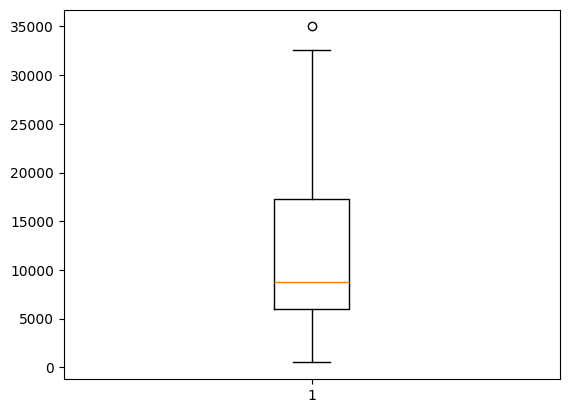

In [9]:
#Plot descriptive statistics
fig = plt.boxplot(descritive_statistics)
fig

* Com o gráfico é possível analisar que não possuímos quase nenhum outlier, facilitando o trabalhar de identificar a massa que será concentrado a política de crédito, ou seja o banco assumiu como estratégia realizar empréstimo para um grupo onde se concentra a maioria dos pedidos, não tem muita aleatoridade. De acordo com o boxplot entre o primeiro quartil e o terceiro quartia as solicitações de crédito estão concentradas a maiorias das massas.

# 2 - Definição da Políticas de crédito e Modelagem

Objetivo é definir o perfil das pessoas onde banco quer aprovar um crédito ou não, após análise exploratória os diretores e gerente do banco chegaram nas seguintes políticas:

Todos os requisitos precisam ser satisfeitos para possuirem a variavel target = 1
Target = 1 (Cliente onde iremos aprovar crédito) e Target = 0 (Cliente onde não possui o perfil desejado pelo banco)

1 - Limite de crédito:

Pedido Mínimo R$ 5.000,00 e máximo R$ 15.000,00

2 - Inadimplência passada

Clientes que tem registro de inadimplência anterior não terá crédito aprovado

se cb_person_default_on_file = Y então o crédito será negado, caso contrario o crédito pode ser concedido

3 - Emprego

Possuir emprego fixo 1 ano ou mais.

4 - Idade

Possuir idade igual ou inferior a 40 anos (Estratégia de direcionar esse produto de crédito para jovens gamers)

5 - Percentual de renda

Não será aprovado empréstimo que comprometa mais que 30% da renda anual

In [10]:
# remove duplicated records
dataset_credit_risk.drop_duplicates(keep="first", inplace=True)

## Policies of credit risk

In [11]:

dataset_credit_risk["credit"] = np.where(
    (dataset_credit_risk["loan_amnt"] >= 5000) & (dataset_credit_risk["loan_amnt"] <= 15000) & \
    (dataset_credit_risk["cb_person_default_on_file"] == "N") & \
    (dataset_credit_risk["person_emp_length"] >= 1) & \
    (dataset_credit_risk["person_age"] <= 40) & \
    (dataset_credit_risk["loan_amnt"] / dataset_credit_risk["person_income"] <= 0.30 ) \
    ,1, 0)

# Display
dataset_credit_risk.head(15)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_percent_income,cb_person_default_on_file,credit
0,22,59000,RENT,123.0,PERSONAL,35000,0.59,Y,0
1,21,9600,OWN,5.0,EDUCATION,1000,0.10,N,0
2,25,9600,MORTGAGE,1.0,MEDICAL,5500,0.57,N,0
3,23,65500,RENT,4.0,MEDICAL,35000,0.53,N,0
4,24,54400,RENT,8.0,MEDICAL,35000,0.55,Y,0
5,21,9900,OWN,2.0,VENTURE,2500,0.25,N,0
6,26,77100,RENT,8.0,EDUCATION,35000,0.45,N,0
7,24,78956,RENT,5.0,MEDICAL,35000,0.44,N,0
8,24,83000,RENT,8.0,PERSONAL,35000,0.42,N,0
9,21,10000,OWN,6.0,VENTURE,1600,0.16,N,0


In [12]:
# Display target 1
dataset_credit_risk[dataset_credit_risk["credit"] == 1].head(15)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_percent_income,cb_person_default_on_file,credit
34,26,300000,MORTGAGE,10.0,MEDICAL,7800,0.03,N,1
44,26,300000,OWN,9.0,HOMEIMPROVEMENT,10000,0.03,N,1
61,22,275000,OWN,6.0,VENTURE,12000,0.04,N,1
68,24,255000,MORTGAGE,9.0,EDUCATION,9600,0.04,N,1
125,23,225000,RENT,8.0,DEBTCONSOLIDATION,7500,0.03,N,1
141,26,215000,MORTGAGE,11.0,EDUCATION,12000,0.06,N,1
165,24,200000,RENT,8.0,MEDICAL,12000,0.06,N,1
166,24,200000,MORTGAGE,8.0,HOMEIMPROVEMENT,12000,0.06,N,1
177,26,200000,MORTGAGE,4.0,EDUCATION,15000,0.07,N,1
179,24,200000,RENT,8.0,EDUCATION,10000,0.05,N,1


In [13]:
# Display target 0
dataset_credit_risk[dataset_credit_risk["credit"] == 0].head(15)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_percent_income,cb_person_default_on_file,credit
0,22,59000,RENT,123.0,PERSONAL,35000,0.59,Y,0
1,21,9600,OWN,5.0,EDUCATION,1000,0.10,N,0
2,25,9600,MORTGAGE,1.0,MEDICAL,5500,0.57,N,0
3,23,65500,RENT,4.0,MEDICAL,35000,0.53,N,0
4,24,54400,RENT,8.0,MEDICAL,35000,0.55,Y,0
5,21,9900,OWN,2.0,VENTURE,2500,0.25,N,0
6,26,77100,RENT,8.0,EDUCATION,35000,0.45,N,0
7,24,78956,RENT,5.0,MEDICAL,35000,0.44,N,0
8,24,83000,RENT,8.0,PERSONAL,35000,0.42,N,0
9,21,10000,OWN,6.0,VENTURE,1600,0.16,N,0


In [14]:
# count of target
dataset_credit_risk["credit"].value_counts()

credit
0    19764
1    12131
Name: count, dtype: int64

In [15]:
# Remove columns unnecessary
dataset_credit_risk = dataset_credit_risk.drop(columns=["person_home_ownership", "loan_intent", "loan_percent_income"])


In [16]:
# Display
dataset_credit_risk.head(15)

,person_age,person_income,person_emp_length,loan_amnt,cb_person_default_on_file,credit
0,22,59000,123.0,35000,Y,0
1,21,9600,5.0,1000,N,0
2,25,9600,1.0,5500,N,0
3,23,65500,4.0,35000,N,0
4,24,54400,8.0,35000,Y,0
5,21,9900,2.0,2500,N,0
6,26,77100,8.0,35000,N,0
7,24,78956,5.0,35000,N,0
8,24,83000,8.0,35000,N,0
9,21,10000,6.0,1600,N,0


In [17]:
# Converter columns object to int (step encoding)
label_encoder = LabelEncoder()
dataset_credit_risk["cb_person_default_on_file"] = label_encoder.fit_transform(dataset_credit_risk["cb_person_default_on_file"])

dataset_credit_risk.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31895 entries, 0 to 32578
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   person_age                 31895 non-null  int64  
 1   person_income              31895 non-null  int64  
 2   person_emp_length          31020 non-null  float64
 3   loan_amnt                  31895 non-null  int64  
 4   cb_person_default_on_file  31895 non-null  int64  
 5   credit                     31895 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 1.7 MB


In [18]:
# Display dataset
dataset_credit_risk["cb_person_default_on_file"].value_counts()

cb_person_default_on_file
0    26209
1     5686
Name: count, dtype: int64

In [19]:
# Separating the dataset features (X)
dataset_credit_risk_x = dataset_credit_risk[["person_age", "person_income", "person_emp_length",
    "loan_amnt", "cb_person_default_on_file"]]

# Display dataset
dataset_credit_risk_x.head()

,person_age,person_income,person_emp_length,loan_amnt,cb_person_default_on_file
0,22,59000,123.0,35000,1
1,21,9600,5.0,1000,0
2,25,9600,1.0,5500,0
3,23,65500,4.0,35000,0
4,24,54400,8.0,35000,1


In [20]:
# Separating the dataset target (y)
dataset_credit_risk_y = dataset_credit_risk["credit"].values.tolist()
type(dataset_credit_risk_y)

list

In [21]:
# Display
dataset_credit_risk_y[0:15]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [22]:
x_train, x_test, y_train, y_test = train_test_split(dataset_credit_risk_x, dataset_credit_risk_y, test_size=0.3)

# Modelo Random forest classifier

In [23]:
# Model
model_RF = RandomForestClassifier(n_estimators=1000)

In [24]:
# Train the model
model_RF = model_RF.fit(x_train, y_train)
print(model_RF)


RandomForestClassifier(n_estimators=1000)


# Metrificando o Modelo

In [25]:
# Accuracy score
accuracy_score_RF = model_RF.score(x_test, y_test)
accuracy_score_RF = float(accuracy_score_RF)
print("Acurácia de Random Forest:", round(accuracy_score_RF * 100,10))

Acurácia de Random Forest: 99.8954958721


In [26]:
# Analyze confusion matrix and classification report
mod_RF = model_RF.predict(x_test)
cm_RF = confusion_matrix(y_test, mod_RF)
print(cm_RF)
cr_RM = classification_report( y_test, mod_RF,output_dict=True)

[[5950    7]
 [   3 3609]]


In [27]:
df_result_RF = pd.DataFrame(cr_RM) 
df_result_RF = df_result_RF.drop(columns=['macro avg', 'weighted avg'])
df_result_RF

,0,1,accuracy
precision,0.999496,0.998064,0.998955
recall,0.998825,0.999169,0.998955
f1-score,0.999160,0.998616,0.998955
support,5957.000000,3612.000000,0.998955


# Predict test

In [ ]:
# example of dataset for prediction
dataset = pd.DataFrame({
    "person_age": [40],
    "person_income": [50000],
    "person_emp_length": [2],
    "loan_amnt": [10000],
    "cb_person_default_on_file": [1]  # 0 para 'N', 1 para 'Y'
})

# Prediction
predict = model_RF.predict(dataset)
print("Aproved credit:", "Yes" if predict[0] == 1 else "No")

Aproved credit: No


# Export Model

In [ ]:
# Path relative to the current working directory
actual_path = os.getcwd()
previous_path = os.path.dirname(actual_path)

# export the model
joblib.dump(model_RF, f"{previous_path}/model/model_credit_risk.pkl")

['/Users/leonardojdss/Desktop/projetos/GenAI-Machine-Learning-MCP/pipeline-machine-learning/model/model_credit_risk.pkl']